In [1]:
import urllib.request, urllib.error, urllib.parse
import os, time, re, json, requests, string, random, concurrent.futures, csv, warnings, nltk
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from tqdm import tqdm
from PIL import Image
from ast import literal_eval
from pylab import plot, show
from bs4 import BeautifulSoup
from matplotlib.lines import Line2D
from scipy import stats
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from scipy.cluster.vq import kmeans, vq
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics, preprocessing
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise import Reader, Dataset, SVD, KNNBasic, BaselineOnly, NormalPredictor, accuracy, dump
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\same\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\same\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# PREPARING

## reading books

In [58]:
# dataset: https://www.kaggle.com/zygmunt/goodbooks-10k --> licence: CC BY-SA 4.0
books = pd.read_csv('datasets-books/dataset-goodbooks-10k/books.csv')

def prepare(x):
    x = str(x)
    x = x.replace("&", "and")
    return x.strip()

books["title"] = books["title"].apply(prepare)
books["original_title"] = books["original_title"].apply(prepare)

new_titles = []
for index_book, row_book in tqdm(books.iterrows()):
    if len(row_book['original_title']) < len(row_book['title']):
        new_titles.append(row_book['original_title'])
    else:
        new_titles.append(row_book['title'])

books["title"] = new_titles

books.head(2)

10000it [00:01, 9671.03it/s]


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [59]:
# dataset: https://www.kaggle.com/dylanjcastillo/7k-books-with-metadata --> license: CC0: Public Domain
books_7k = pd.read_csv("datasets-books/dataset-7k-books/books.csv")
books_7k = books_7k[["title", "description", "categories"]]
books_7k.head(2)

,title,description,categories
0,Gilead,A NOVEL THAT READERS and critics have been eag...,Fiction
1,Spider's Web,A new 'Christie for Christmas' -- a full-lengt...,Detective and mystery stories


In [60]:
# https://www.kaggle.com/jdobrow/57000-books-with-metadata-and-blurbs --> licence: ?
books_57k = pd.read_csv("datasets-books/dataset-57k-books/books_with_blurbs.csv")
books_57k = books_57k[["Title", "Blurb"]]
books_57k = books_57k.rename(columns={'Title': 'title', "Blurb": "description"})
books_57k.head(2)

,title,description
0,Decision in Normandy,"Here, for the first time in paperback, is an o..."
1,Flu: The Story of the Great Influenza Pandemic...,"The fascinating, true story of the world's dea..."


In [61]:
# dataset: https://www.kaggle.com/sp1thas/book-depository-dataset --> licence: CC BY-NC-SA 4.0
book_depository = pd.read_csv("datasets-books/dataset-book-depository/dataset.csv")
book_depository_categories = pd.read_csv("datasets-books/dataset-book-depository/categories.csv")
category_list = []
for book, row in tqdm(book_depository.iterrows()):
    c_list = literal_eval(row["categories"])
    c_book = []
    for c in c_list:
        get_c = book_depository_categories[book_depository_categories["category_id"] == c]["category_name"].item()
        c_book.append(get_c)
    category_list.append(c_book)

book_depository["categories"] = category_list
book_depository["categories"] = book_depository["categories"].apply(lambda x: ', '.join(x))
book_depository = book_depository[["title", "description", "categories"]]
book_depository.head(2)

56009it [01:56, 482.60it/s]


,title,description,categories
0,1984,Renowned urban artist Shepard Fairey's new loo...,"Contemporary Fiction, Classic Books & Novels, ..."
1,100 Deadly Skills: Survival Edition : The SEAL...,"These 100 skills, adapted for civilians from a...","Encyclopaedias & Reference Works, Reference Wo..."


In [62]:
# dataset: https://www.kaggle.com/meetnaren/goodreads-best-books --> licence: ?
books_2018_best = pd.read_csv("datasets-books/dataset-goodreads-2018-best-books/book_data.csv")
def prepare(x):
    x = str(x)
    x = x.replace('|', ", ")
    return x
books_2018_best["genres"] = books_2018_best["genres"].apply(prepare)
books_2018_best = books_2018_best[["book_title", "book_desc", "genres"]]
books_2018_best = books_2018_best.rename(columns={'book_title': 'title', "book_desc": "description", "genres": "categories"})
books_2018_best.head(2)

,title,description,categories
0,The Great Alone,"Alaska, 1974.Unpredictable. Unforgiving. Untam...","Fiction, Historical, Historical Fiction, Audio..."
1,Circe,"In the house of Helios, god of the sun and mig...","Fantasy, Fiction, Fantasy, Mythology, Historic..."


In [63]:
# dataset: https://www.kaggle.com/austinreese/goodreads-books --> licence: CC0: Public Domain
books_31_feat = pd.read_csv("datasets-books/dataset-goodreads-books-31-features/goodreads_books.csv")
def prepare(x):
    x = str(x)
    return re.sub('\s*[0-9]', '', x)
books_31_feat["genre_and_votes"] = books_31_feat["genre_and_votes"].apply(prepare)
books_31_feat = books_31_feat[["title", "description", "genre_and_votes"]]
books_31_feat = books_31_feat.rename(columns={"genre_and_votes": "categories"})
books_31_feat.head(2)

,title,description,categories
0,Inner Circle,Reed Brennan arrived at Easton Academy expecti...,"Young Adult, Mystery, Romance"
1,A Time to Embrace,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,...","Christian Fiction, Christian, Fiction, Romance"


In [64]:
# dataset: https://www.kaggle.com/bilalyussef/google-books-dataset --> licence: google?
books_google = pd.read_csv("datasets-books/dataset-google-books/google_books_1299.csv")
books_google = books_google[["title", "description", "generes"]]
books_google = books_google.rename(columns={"generes": "categories"})
books_google.head(2)

,title,description,categories
0,Attack on Titan: Volume 13,NO SAFE PLACE LEFT At great cost to the Garris...,none
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Determined to make a new start in her quaint h...,"Fiction , Mystery &amp, Detective , Cozy , Gen..."


In [65]:
# dataset: https://www.kaggle.com/ymaricar/cmu-book-summary-dataset --> licence: CC BY-SA 3.0
books_cmu = pd.read_csv("datasets-books/dataset-cmu-book-summary/booksummaries.csv")
books_cmu = books_cmu[["BookTitle", "Summary", "GenreString"]]
books_cmu = books_cmu.rename(columns={'BookTitle': 'title', "Summary": "description", "GenreString": "categories"})
books_cmu.head(2)

,title,description,categories
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...",Roman à clef Satire Children's literature Spec...
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",Science Fiction Novella Speculative fiction Ut...


## merging

In [66]:
def count_nan():
    a = books_cmu["description"].isna().sum(), books_cmu["categories"].isna().sum()
    b = book_depository["description"].isna().sum(), book_depository["categories"].isna().sum()
    c = books_7k["description"].isna().sum(), books_7k["categories"].isna().sum()
    d = books_2018_best["description"].isna().sum(), books_2018_best["categories"].isna().sum()
    e = books_31_feat["description"].isna().sum(), books_31_feat["categories"].isna().sum()
    f = books_google["description"].isna().sum(), books_google["categories"].isna().sum()
    g = books_57k["description"].isna().sum(), books_57k.shape[0]
    print(a, b, c, d, e, f, g)

count_nan()
books_cmu = books_cmu.dropna()
book_depository = book_depository.dropna()
books_7k = books_7k.dropna()
books_2018_best = books_2018_best.dropna()
books_31_feat = books_31_feat.dropna()
books_google = books_google.dropna()
count_nan()

(0, 0) (4022, 0) (262, 99) (5, 0) (2575, 0) (3, 0) (0, 57510)
(0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 57510)


In [106]:
books_all = pd.concat([books_cmu, book_depository, books_7k, books_2018_best, books_31_feat, books_google, books_57k])
books_all

,title,description,categories
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...",Roman à clef Satire Children's literature Spec...
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",Science Fiction Novella Speculative fiction Ut...
2,The Plague,The text of The Plague is divided into five p...,Existentialism Fiction Absurdist fiction Novel
3,A Fire Upon the Deep,The novel posits that space around the Milky ...,Hard science fiction Science Fiction Speculati...
4,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...",War novel Roman à clef
...,...,...,...
57505,Tainted Trail,"Ukiah Oregon, half-man and half-alien raised b...",NaN
57506,Twelve Mile Limit,"On a Friday in early November, four people hea...",NaN
57507,The Man With the Red Tattoo (James Bond 007),On a quiet late-night flight from Tokyo to Lon...,NaN
57508,"Iron Fist (Star Wars: X-Wing Series, Book 6)",They are the Rebel Alliance's ultimate strike ...,NaN


In [107]:
"shapes: ", books_all.shape, len(books_all["title"].unique())

('shapes: ', (180114, 3), 153165)

In [108]:
"nan count: ", books_all["description"].isna().sum(), books_all["categories"].isna().sum()

('nan count: ', 0, 57510)

In [109]:
books_all = books_all[~((books_all['title'].duplicated(keep=False)) & (books_all.isnull().any(axis=1)))]
"nan count: ", books_all["description"].isna().sum(), books_all["categories"].isna().sum()

('nan count: ', 0, 43624)

In [110]:
"shapes: ", books_all.shape, len(books_all["title"].unique())

('shapes: ', (166228, 3), 151197)

In [111]:
books_all = books_all.drop_duplicates(subset=['title'])
"shapes: ", books_all.shape, len(books_all["title"].unique())

('shapes: ', (151197, 3), 151197)

## concat all

In [229]:
books = pd.read_csv('datasets-books/dataset-goodbooks-10k/books.csv')

def prepare(x):
    x = str(x)
    x = x.replace("&", "and")
    return x.strip()

books["title"] = books["title"].apply(prepare)
books["original_title"] = books["original_title"].apply(prepare)

new_titles = []
for index_book, row_book in tqdm(books.iterrows()):
    if len(row_book['original_title']) < len(row_book['title']):
        new_titles.append(row_book['original_title'])
    else:
        new_titles.append(row_book['title'])

books["title"] = new_titles

books.head(2)

books_summary_1 = books.merge(books_all, left_on='title', right_on='title', how='left')
books_summary_2 = books.merge(books_all, left_on='title', right_on='title', how='inner')

10000it [00:01, 8250.86it/s]


In [230]:
books_summary_1.shape, books_summary_2.shape

((10000, 25), (7117, 25))

In [231]:
books_summary_1.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,Science Fiction Adventure novel Alternate hist...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...",Children's literature Fantasy Speculative fict...


In [234]:
books_summary_1["description"].isna().sum(), books_summary_1["categories"].isna().sum()

(2883, 3036)

# remove chars

In [77]:
def non_ascii(x):
    if type(x) == str:
        x = x.replace('\"', '')
        x = x.replace('\\', '')
        x = x.replace("'", '')
        x = x.replace('\n', '')
        x = x.replace('\r', '')
        # x = x.replace('<', '')
        # x = x.replace('>', '')
        x = ''.join([i if ord(i) < 128 else ' ' for i in x])
    return x

def add_comma(x):
    x = str(x)
    if "," not in x:
        x = x.replace("fiction", "fiction,")
        x = x.replace("literature", "literature,")
        x = x.replace("Fiction", "Fiction,")
        x = x.replace("novel", "novel,")
        x = x.replace("book", "book,")
        x = x.replace("history", "history,")
    return x
        
books_summary_end["categories"] = books_summary_end["categories"].apply(add_comma)
books_summary_end = books_summary_end.applymap(non_ascii)

In [78]:
books_summary_end.to_csv("all_books_with_descr_4_ed.csv", index=False)

# crawler
## crawled 3.000 books

In [ ]:
count1 = 0
write_html = False
skipped = []
skipped_descr = []
skipped_title = []
skipped_genre = []
for index, row in tqdm(books_summary_1.iterrows()):
    if pd.isnull(books_summary_1.iloc[index]["description"]) or pd.isnull(books_summary_1.iloc[index]["categories"]):
        url = "https://www.goodreads.com/book/show/" + str(row["book_id"])
        response = urllib.request.urlopen(url)
        webContent = response.read()
        if write_html:
            with open("htmls/" + str(index) + "-" + str(row["book_id"]) + ".html", 'wb') as f: # -> plus 2 seconds
                f.write(webContent)
                
        source = BeautifulSoup(webContent, 'html.parser')
        summary = source.find("div", attrs={"id": "description"})
        try:
            summary = summary.find_all("span")
        except:
            skipped.append((index, str(row["book_id"])))
        try:
            summary = summary[1]
        except:
            try:
                summary = summary[0]
            except:
                skipped_descr.append((index, str(row["book_id"])))
        try:
            books_summary_1.at[index, "description"] = summary.text
        except:
            skipped_descr.append((index, str(row["book_id"])))
        
        try:  
            book_title = source.find("h1", attrs={"id": "bookTitle"})
            books_summary_1.at[index, "title"] = book_title.text.strip()
        except:
            skipped_title.append((index, str(row["book_id"])))
        
        genre = source.find_all("a", attrs={"class": "actionLinkLite bookPageGenreLink"}, href=True)
        genres = ""
        try:
            genres += genre[0].text
        except:
            skipped_genre.append((index, str(row["book_id"])))
            pass
        try:
            genres += ", " + genre[1].text
        except:
            pass
        try:
            genres += ", " + genre[2].text
        except:
            pass
        if genres != "":
            books_summary_1.at[index, "categories"] = genres
        
        # print("title:", book_title.text.strip(), "\n")
        # print("description:", summary.text, "\n")
        # print("genres:", genres, "\n")
        time.sleep(0.5)

print("continue:", count1)

# csv to sql

In [574]:
def non_ascii(x):
    if type(x) == str:
        x = x.replace('\"', '')
        x = x.replace('\\', '')
        x = x.replace("'", '')
        x = x.replace('\n', '')
        x = x.replace('\r', '')
        # x = x.replace('<', '')
        # x = x.replace('>', '')
        x = ''.join([i if ord(i) < 128 else '' for i in x])
    return x

"""
movies_recommender_1 = pd.read_csv("movies_with_soup.csv")
movies_recommender_2 = movies_recommender_1.drop(["soup"], axis=1)
movies_recommender_2.to_csv("movies_with_soup_1.csv", index=False)
"""

movies_recommender_1 = pd.read_csv("movies_with_soup_1.csv")
movies_recommender_1 = movies_recommender_1.drop_duplicates(subset=['id'])
movies_recommender_1["index"] = range(0, movies_recommender_1.shape[0])
print(movies_recommender_1.shape)
movies_nans = movies_recommender_1.applymap(non_ascii)
movies_nans.to_csv("movies_with_soup_2.csv", index=False)
print(movies_nans.shape)
movies_nans.head(2)

(45433, 22)
(45433, 22)


,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,index
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,0
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Franais",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,1


In [200]:
openFile = open('all_books_ratings_new.csv', 'r')
csvFile = csv.reader(openFile)
header = next(csvFile)
headers = map((lambda x: '`' + x + '`'), header)
insert = 'INSERT INTO rcsystem_bookratings (' + ", ".join(headers) + ") VALUES "
sql = []
# all_movie_id = movies_recommender_1["id"].tolist()
# dupl_dict = {}
for row in csvFile:
    values = map((lambda x: '"' + x + '"'), row)
    # k = row[0]
    # if k in dupl_dict:
    #     continue
    # dupl_dict[k] = 1
    # movie_id = row[1]
    if int(row[1]) <= 671: # for limitations, user count is 671
        row[0] = int(row[0])
        row[0] = int(row[0]) - 1
        row[0] = str(row[0])
        content = insert + "(" + ", ".join(values) + ");"
        sql.append(content)

openFile.close()

with open('book_user_rated.sql', 'w') as f:
    for item in sql:
        f.write("%s\n" % item)

# END

In [86]:
books_summary_end = pd.read_csv('all_books_with_descr_4_ed.csv')

In [87]:
books_summary_end.isna().sum()

id                             0
book_id                        0
best_book_id                   0
work_id                        0
books_count                    0
isbn                         700
isbn13                       585
authors                        0
original_publication_year     21
original_title               589
title                          0
language_code                  0
average_rating                 0
ratings_count                  0
work_ratings_count             0
work_text_reviews_count        0
ratings_1                      0
ratings_2                      0
ratings_3                      0
ratings_4                      0
ratings_5                      0
image_url                      0
small_image_url                0
description                    0
categories                     0
dtype: int64

# creating model

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_descr(x):
    x = str(x)
    word_tokens = word_tokenize(x)
    filtered_sentence = [w.lower() for w in word_tokens if not w in stop_words and w.isalpha()]
    return " ".join(filtered_sentence)
        
books_summary_end["clean_description"] = books_summary_end["description"].apply(clean_descr)

In [120]:
books_summary_end.to_csv("all_books_with_descr_4_with_clean.csv", index=False)
books_summary_end.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories,clean_description
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,"Science Fiction, Adventure novel, Alternate hi...",the hunger games takes place nation known pane...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPr",1997.0,Harry Potter and the Philosophers Stone,...,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...","Childrens literature, Fantasy Speculative fict...",before start novel voldemort considered evil p...


In [128]:
books_ascii = pd.read_csv("datasets-book-old/books_ascii.csv")
books_ascii.id

0          0
1          1
2          2
3          3
4          4
        ... 
7066    7066
7067    7067
7068    7068
7069    7069
7070    7070
Name: id, Length: 7071, dtype: int64

In [138]:
books_summary_end.id = range(0, 10000)
books_summary_end.to_csv("all_books_with_descr_4_with_clean_true_id.csv", index=False)
books_summary_end.id

0          0
1          1
2          2
3          3
4          4
        ... 
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Name: id, Length: 10000, dtype: int32

In [135]:
books = books_summary_end
# books = pd.read_csv("datasets-book-old/books_ascii.csv")
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books['description'])
cosine = cosine_similarity(tfidf_matrix, tfidf_matrix)
tfidf_matrix.shape

(10000, 1184795)

In [174]:
def get_title_from_index(book_id):
    return books[books["id"] == book_id]["title"].values[0]

def get_index_from_title(title):
    return books[books["title"] == title]["id"].values[0]

def get_recommendations(book, cosine=cosine):
    book_index = int(get_index_from_title(book))
    print("book_index:", book_index)
    similar_books = list(enumerate(cosine[book_index]))
    sortedbooks = sorted(similar_books, key=lambda x: x[1], reverse=True)
    print("{:>1} {:>40} \t {:>40} {:>15}".format("Index:", "Title:", "Author:", "Similarity:"))
    for i, book in enumerate(sortedbooks[1:6]):
        title = get_title_from_index(book[0])
        author = books.authors[books["id"] == book[0]].values[0]
        similarity = book[1]
        print("{:>5}: {:>40} \t {:>40} {:>15.4f}".format(i + 1, title, author, similarity))

In [131]:
get_recommendations("The Two Towers") # old model

Index:                                   Title: 	                                  Author:     Similarity:
    1:                    The Lord of the Rings 	                           J.R.R. Tolkien          0.5426
    2:                   The Return of the King 	                           J.R.R. Tolkien          0.4682
    3:               The Fellowship of the Ring 	                           J.R.R. Tolkien          0.3881
    4:     The Hobbit and The Lord of the Rings 	                           J.R.R. Tolkien          0.1311
    5:                  My Side of the Mountain 	                    Jean Craighead George          0.1089


In [175]:
get_recommendations("The Two Towers") # new model

book_index: 154
Index:                                   Title: 	                                  Author:     Similarity:
    1:                    The Lord of the Rings 	                           J.R.R. Tolkien          0.5173
    2:                   The Return of the King 	                           J.R.R. Tolkien          0.4457
    3:               The Fellowship of the Ring 	                           J.R.R. Tolkien          0.3614
    4: The Lord of the Rings: The Return of the King: Visual Companion 	                              Jude Fisher          0.1426
    5: J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings 	                           J.R.R. Tolkien          0.1322


In [167]:
def clean_data(x):
    x = str(x)
    word_tokens = word_tokenize(x)
    filtered_sentence = [w.lower() for w in word_tokens if w.isalpha()] # not w in stop_words and
    x =  " ".join(filtered_sentence)
    return str.lower(x.replace(" ", ""))

features = ['title', 'authors', 'description', 'categories']
filledna = books_summary_end[features]

for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
filledna.head(2)

,title,authors,description,categories
0,thehungergames,suzannecollins,thehungergamestakesplaceinanationknownaspaneme...,sciencefictionadventurenovelalternatehistorysp...
1,harrypotterandthephilosophersstone,rowlingmarygrandpr,beforethestartofthenovelvoldemortconsideredthe...,childrensliteraturefantasyspeculativefictionfi...


In [168]:
def create_soup(x):
    return x['title'] + ' ' + x['authors'] + ' ' + x['description'] + ' ' + x['categories']

books_summary_end['soup'] = filledna.apply(create_soup, axis=1)
books_summary_end['soup']

0       thehungergames suzannecollins thehungergamesta...
1       harrypotterandthephilosophersstone rowlingmary...
2       twilight stepheniemeyer isabellabellaswanmoves...
3       tokillamockingbird harperlee thebookopenswitht...
4       thegreatgatsby scottfitzgerald thestorybeginsw...
                              ...                        
9995    bayoumoon ilonaandrews theedgeliesbetweenworld...
9996    meansofascent robertcaro robertcaroslifeoflynd...
9997    themauritiuscommand patrickobrian whenthenovel...
9998    cinderellaatemydaughterdispatchesfromthefrontl...
9999    thefirstworldwar johnkeegan thefirstworldwarcr...
Name: soup, Length: 10000, dtype: object

In [169]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(books_summary_end['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [170]:
get_recommendations('The Two Towers', cosine_sim2)

Index:                                   Title: 	                                  Author:     Similarity:
    1:                               The Hobbit 	                           J.R.R. Tolkien          0.2500
    2:               The Fellowship of the Ring 	                           J.R.R. Tolkien          0.2500
    3:                   The Return of the King 	                           J.R.R. Tolkien          0.2500
    4:                    The Lord of the Rings 	                           J.R.R. Tolkien          0.2500
    5:                       The Amber Spyglass 	                           Philip Pullman          0.2500


In [176]:
get_recommendations('The Hobbit', cosine_sim2)

book_index: 6
Index:                                   Title: 	                                  Author:     Similarity:
    1:                               The Hobbit 	 Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sean Deming          0.7500
    2:               The Fellowship of the Ring 	                           J.R.R. Tolkien          0.2500
    3:                           The Two Towers 	                           J.R.R. Tolkien          0.2500
    4:                   The Return of the King 	                           J.R.R. Tolkien          0.2500
    5:                    The Lord of the Rings 	                           J.R.R. Tolkien          0.2500


In [171]:
books_summary_end.to_csv("all_books_with_descr_4_with_clean_true_id_with_soup.csv", index=False)

In [173]:
books_summary_end.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories,clean_description,soup
0,0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,"Science Fiction, Adventure novel, Alternate hi...",the hunger games takes place nation known pane...,thehungergames suzannecollins thehungergamesta...
1,1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPr",1997.0,Harry Potter and the Philosophers Stone,...,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...","Childrens literature, Fantasy Speculative fict...",before start novel voldemort considered evil p...,harrypotterandthephilosophersstone rowlingmary...


## user based recommender

In [205]:
ratings = pd.read_csv('datasets-books/dataset-goodbooks-10k/ratings.csv')
books_with_descr = pd.read_csv('all_books_with_descr_4_with_clean_true_id_with_soup.csv')
book_original = pd.read_csv('datasets-books/dataset-goodbooks-10k/books.csv')

In [186]:
books_with_descr.shape, ratings.shape

((10000, 27), (981756, 3))

In [187]:
ratings.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [188]:
books_with_descr.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories,clean_description,soup
0,0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,"Science Fiction, Adventure novel, Alternate hi...",the hunger games takes place nation known pane...,thehungergames suzannecollins thehungergamesta...
1,1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPr",1997.0,Harry Potter and the Philosophers Stone,...,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...","Childrens literature, Fantasy Speculative fict...",before start novel voldemort considered evil p...,harrypotterandthephilosophersstone rowlingmary...


In [189]:
C = books_with_descr['average_rating'].mean()
m = books_with_descr['ratings_count'].quantile(0.9)
trending_books = books_with_descr.copy().loc[books_with_descr['ratings_count'] >= m]

def weighted_rating(x, m=m, C=C):
    v = x['ratings_count']
    R = x['average_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

trending_books['score'] = trending_books.apply(weighted_rating, axis=1)
trending_books = trending_books.sort_values('score', ascending=False)
trending_books[['title', 'ratings_count', 'average_rating', 'score']].head(10)

,title,ratings_count,average_rating,score
24,Harry Potter and the Deathly Hallows,1746574,4.61,4.578926
26,Harry Potter and the Half-Blood Prince,1678823,4.54,4.511454
17,Harry Potter and the Prisoner of Azkaban,1832823,4.53,4.504224
23,Harry Potter and the Goblet of Fire,1753043,4.53,4.503111
421,Harry Potter Series Box Set,190050,4.74,4.495659
134,A Storm of Swords,469022,4.54,4.450127
191,The Name of the Wind,400101,4.55,4.445690
20,Harry Potter and the Order of the Phoenix,1735368,4.46,4.436452
1,Harry Potter and the Philosophers Stone,4602479,4.44,4.431228
160,The Return of the King,463959,4.51,4.424371


In [190]:
reader = Reader()
data = Dataset.load_from_df(ratings[['book_id', 'user_id', 'rating']], reader)
kf = KFold(n_splits=5)
svd = SVD()

for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8431
RMSE: 0.8439
RMSE: 0.8435
RMSE: 0.8429
RMSE: 0.8442


In [191]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [192]:
ratings[ratings['user_id'] == 7]

,book_id,user_id,rating
58397,585,7,4
90897,910,7,4
95497,956,7,5
106997,1071,7,4
119784,1199,7,4
...,...,...,...
823644,8320,7,5
832512,8413,7,3
834342,8432,7,4
855691,8654,7,5


In [193]:
svd.predict(1, 302, 3), svd.predict(1, 302, 3).est

(Prediction(uid=1, iid=302, r_ui=3, est=4.4897874102804165, details={'was_impossible': False}),
 4.4897874102804165)

In [209]:
user_id = 7
book_rating_pred = []
user1_not_rated = ratings[~(ratings['user_id'] == user_id)]
for book_id in user1_not_rated["book_id"].unique().tolist():
    pred = svd.predict(user_id, book_id, 3)
    book_rating_pred.append((books_with_descr[books_with_descr["id"] == (pred.iid - 1)]["title"].values[0], pred.est))

book_rating_pred = sorted(book_rating_pred, key=lambda x: x[1], reverse=True)
for book, pred in book_rating_pred[:15]:
    print("{:>60} {:>10.3f}".format(book, pred)) # not working but no other models found

                                               The Godfather      5.000
                                                  Nightshade      5.000
                                               Metamorphoses      5.000
                       The Myth of Sisyphus and Other Essays      5.000
                                                       Fever      5.000
                                            The Killing Game      5.000
                                      The Wrath of Mulgarath      5.000
                                         The Best Laid Plans      5.000
                                                 The Remnant      5.000
                                                   White Cat      5.000
Killing Patton: The Strange Death of World War IIs Most Audacious General      5.000
        Conversations With God: An Uncommon Dialogue, Book 3      5.000
                                Shall We Tell the President?      5.000
                                           T is for

In [210]:
dump.dump("user_based_book", algo=svd)
# _, loaded_algo = dump.load("user_based_book")

# ratings.csv

In [212]:
ratings.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [213]:
ratings["book_id"] = ratings["book_id"].apply(lambda x: x - 1)

In [215]:
ratings.tail(2)

,book_id,user_id,rating
981754,9999,50124,5
981755,9999,51328,1


In [217]:
ratings.to_csv("ratings_true_book_id.csv", index=False)

# movies

In [ ]:
# https://www.kaggle.com/neha1703/movie-genre-from-its-poster   -> posters
# https://www.kaggle.com/rounakbanik/the-movies-dataset         -> description, category, overall ratings, user ratings, crew
# https://www.kaggle.com/tmdb/tmdb-movie-metadata               -> description, category, overall ratings,               crew
# https://www.kaggle.com/jrobischon/wikipedia-movie-plots       -> description, category, overall ratings,               crew
# https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset -> description, category, overall ratings,               crew
# https://www.kaggle.com/stefanoleone992/filmtv-movies-dataset  -> description, category, overall ratings,               crew
# https://www.kaggle.com/shivamb/netflix-shows                  -> description, category,                                crew
# https://www.kaggle.com/danielgrijalvas/movies                 ->              category, overall ratings,               crew
# https://www.kaggle.com/sherinclaudia/movielens                ->              category,                  user ratings,
# https://www.kaggle.com/jneupane12/movielens                   ->              category,                  user ratings,
# https://www.kaggle.com/raidevesh05/movie-ratings-dataset      ->                        overall ratings
# https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset -> genre, user ratings

# reading the movie dataset

In [80]:
# dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset --> licence: CC0: Public Domain
rating_small = pd.read_csv("datasets-movies/dataset-the-movie/ratings_small.csv")
print(rating_small.shape)
rating_small.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [81]:
rating_large = pd.read_csv("datasets-movies/dataset-the-movie/ratings.csv")
print(rating_large.shape)
rating_large.head(2)

(26024289, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [270]:
movies = pd.read_csv("datasets-movies/dataset-the-movie/movies_metadata.csv")
# img url: https://image.tmdb.org/t/p/original/ + poster_path
# movies = movies.fillna("")

wrong_id = []
counter = 0
for i in movies['id']:
    try:
        i = int(i)
    except:
        wrong_id.append(counter)
    counter += 1
movies = movies.drop([19730, 29503, 35587]) # [19730, 29503, 35587]

def clean_imdb_id(x):
    if type(x) == str:
        x = x.split("tt")[1]
    try:
        x = int(x)
    except:
        x = -1
    return x
movies["clean_imdb_id"] = movies["imdb_id"].apply(clean_imdb_id)

print(movies.shape)
movies.head(2)

(45463, 25)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,clean_imdb_id
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,114709
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,113497


In [190]:
#movies["clean_imdb_id"] = movies["clean_imdb_id"].astype(int)
movies["clean_imdb_id"]

0         114709
1         113497
2         113228
3         114885
4         113041
          ...   
45461    6209470
45462    2028550
45463     303758
45464       8536
45465    6980792
Name: clean_imdb_id, Length: 45463, dtype: int64

In [218]:
credits = pd.read_csv("datasets-movies/dataset-the-movie/credits.csv")
print(credits.shape)
credits.head(2)

(45476, 3)


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [154]:
keywords = pd.read_csv("datasets-movies/dataset-the-movie/keywords.csv")
print(keywords.shape)
keywords.head(2)

(46419, 2)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [155]:
links_small = pd.read_csv("datasets-movies/dataset-the-movie/links_small.csv")
print(links_small.shape)
links_small.head(2)

(9125, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [156]:
links_large = pd.read_csv("datasets-movies/dataset-the-movie/links.csv")
print(links_large.shape)
links_large.head(2)

(45843, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [157]:
# dataset: https://www.kaggle.com/neha1703/movie-genre-from-its-poster --> licence: ?
posters = pd.read_csv("datasets-movies/dataset-posters/imdbid_posterurl.csv", usecols=["imdbId", "Poster"])
posters = posters.dropna()
posters.head(2)

,imdbId,Poster
0,114709,https://images-na.ssl-images-amazon.com/images...
1,113497,https://images-na.ssl-images-amazon.com/images...


In [203]:
movie_links_with_poster = links_large.merge(posters, left_on="imdbId", right_on="imdbId", how="left")
movie_links_with_poster = movie_links_with_poster.rename(columns={'imdbId': 'clean_imdb_id', 'Poster': 'poster'})
movie_links_with_poster = movie_links_with_poster[["clean_imdb_id", "poster"]]
movie_links_with_poster["clean_imdb_id"] = movie_links_with_poster["clean_imdb_id"].astype('int')
print(movie_links_with_poster.shape)
movie_links_with_poster.head(2)

(46435, 2)


,clean_imdb_id,poster
0,114709,https://images-na.ssl-images-amazon.com/images...
1,113497,https://images-na.ssl-images-amazon.com/images...


In [220]:
movie_links_with_poster.isna().sum()

clean_imdb_id       0
poster           7092
dtype: int64

In [271]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

movies = pd.merge(movies, credits, on='id', how="left")
movies = pd.merge(movies, keywords, on='id', how="left")
movies = pd.merge(movies, movie_links_with_poster, on='clean_imdb_id', how="left")

print(movies.shape)
movies.head(2)

(47220, 29)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,clean_imdb_id,cast,crew,keywords,poster
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,114709,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",https://images-na.ssl-images-amazon.com/images...
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,113497,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",https://images-na.ssl-images-amazon.com/images...


In [272]:
movies.isna().sum()

adult                        0
belongs_to_collection    42591
budget                       0
genres                       0
homepage                 39054
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   995
popularity                   4
poster_path                399
production_companies         4
production_countries         4
release_date                88
revenue                      4
runtime                    268
spoken_languages             4
status                      86
tagline                  26105
title                        4
video                        4
vote_average                 4
vote_count                   4
clean_imdb_id                0
cast                         1
crew                         1
keywords                     1
poster                    7183
dtype: int64

In [273]:
movies = movies.fillna('')

In [274]:
movies.isna().sum()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
clean_imdb_id            0
cast                     0
crew                     0
keywords                 0
poster                   0
dtype: int64

# clearing

In [275]:
# genres, cast, crew, keywords, spoken_languages, production_countries, production_companies, belongs_to_collection
def get_clean(x):
    if x == np.nan or x == '' or x == 'nan':
        return ''
    try:
        x = literal_eval(x)
    except:
        print(x)
    cleaned = []
    if isinstance(x, list):
        if len(x) >= 3:
            for i in x[:3]:
                cleaned.append(i["name"])
            return ", ".join(cleaned)
        else:
            for i in x:
                cleaned.append(i["name"])
            return ", ".join(cleaned)
    return ''

def get_director(x):
    if x == np.nan or x == '' or x == 'nan':
        return ''
    x = literal_eval(x)
    for i in x:
        if i["job"] == "Director":
            return i["name"]
    return ''

def get_collection(x):
    if x == np.nan or x == '' or x == 'nan':
        return ''
    x = literal_eval(x)
    return x["name"]

"""
movies['clean_genres'] = movies['genres'] \
    .fillna('[]') \
    .apply(literal_eval) \
    .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) \
    .apply(lambda x: ", ".join(x) if isinstance(x, list) else "")
"""

movies['clean_genres'] = movies['genres'].apply(get_clean)
movies['clean_cast'] = movies['cast'].apply(get_clean)
movies['director'] = movies['crew'].apply(get_director)
movies['clean_keywords'] = movies['keywords'].apply(get_clean)
movies['clean_spoken_languages'] = movies['spoken_languages'].apply(get_clean)
movies['clean_production_countries'] = movies['production_countries'].apply(get_clean)
movies['clean_production_companies'] = movies['production_companies'].apply(get_clean)
movies['clean_belongs_to_collection'] = movies['belongs_to_collection'].apply(get_collection)

movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,clean_imdb_id,cast,crew,keywords,poster,clean_genres,clean_cast,director,clean_keywords,clean_spoken_languages,clean_production_countries,clean_production_companies,clean_belongs_to_collection
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,3.73554e+08,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415,114709,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",https://images-na.ssl-images-amazon.com/images...,"Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,Toy Story Collection
1,False,,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,2.62797e+08,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413,113497,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",https://images-na.ssl-images-amazon.com/images...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on children's...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",


In [276]:
movies.to_csv("clean_movies_1.csv", index=False)

In [280]:
movies = movies[[
    "id", 
    "imdb_id",
    "clean_imdb_id",
    "original_language", 
    "original_title",
    "title",
    "overview",
    "clean_genres",
    "clean_cast",
    "director",
    "clean_keywords",
    "clean_spoken_languages",
    "clean_production_countries",
    "clean_production_companies",
    "popularity", 
    "release_date",
    "tagline",
    "vote_average",
    "vote_count",
    "runtime",
    "poster",
]]

movies.head(5)

,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,clean_genres,clean_cast,director,clean_keywords,clean_spoken_languages,clean_production_countries,clean_production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.9469,1995-10-30,,7.7,5415,81,https://images-na.ssl-images-amazon.com/images...
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on children's...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.0155,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413,104,https://images-na.ssl-images-amazon.com/images...
2,15602,tt0113228,113228,en,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,"Romance, Comedy","Walter Matthau, Jack Lemmon, Ann-Margret",Howard Deutch,"fishing, best friend, duringcreditsstinger",English,United States of America,"Warner Bros., Lancaster Gate",11.7129,1995-12-22,Still Yelling. Still Fighting. Still Ready for...,6.5,92,101,https://images-na.ssl-images-amazon.com/images...
3,31357,tt0114885,114885,en,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","Comedy, Drama, Romance","Whitney Houston, Angela Bassett, Loretta Devine",Forest Whitaker,"based on novel, interracial relationship, sing...",English,United States of America,Twentieth Century Fox Film Corporation,3.85949,1995-12-22,Friends are the people who let you be yourself...,6.1,34,127,https://images-na.ssl-images-amazon.com/images...
4,11862,tt0113041,113041,en,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,"Steve Martin, Diane Keaton, Martin Short",Charles Shyer,"baby, midlife crisis, confidence",English,United States of America,"Sandollar Productions, Touchstone Pictures",8.38752,1995-02-10,Just When His World Is Back To Normal... He's ...,5.7,173,106,https://images-na.ssl-images-amazon.com/images...


In [278]:
movies.isna().sum()

id                            0
imdb_id                       0
clean_imdb_id                 0
original_language             0
original_title                0
title                         0
overview                      0
clean_genres                  0
clean_cast                    0
director                      0
clean_keywords                0
clean_spoken_languages        0
clean_production_countries    0
clean_production_companies    0
popularity                    0
release_date                  0
tagline                       0
vote_average                  0
vote_count                    0
runtime                       0
poster                        0
dtype: int64

In [281]:
movies.to_csv("clean_movies_end.csv", index=False)

In [282]:
movies.shape

(47220, 21)

In [283]:
movies_test = movies.replace('', np.nan)
movies_test.head(2)

,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,clean_genres,clean_cast,director,clean_keywords,clean_spoken_languages,clean_production_countries,clean_production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.9469,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on children's...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.0155,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...


In [284]:
movies_test.isna().sum()

id                                0
imdb_id                          17
clean_imdb_id                     0
original_language                11
original_title                    0
title                             4
overview                        995
clean_genres                   2532
clean_cast                     2506
director                        920
clean_keywords                14985
clean_spoken_languages         4113
clean_production_countries     6531
clean_production_companies    12388
popularity                        4
release_date                     88
tagline                       26105
vote_average                      4
vote_count                        4
runtime                         268
poster                         7183
dtype: int64

In [285]:
movies_test.to_csv("clean_movies_end_with_nan.csv", index=False)

# ratings

In [80]:
rating_small = pd.read_csv("datasets-movies/dataset-the-movie/ratings_small.csv")
print(rating_small.shape)
rating_small.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [82]:
reader = Reader()
data = Dataset.load_from_df(rating_small[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
svd = SVD()

for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8982
RMSE: 0.8980
RMSE: 0.8942
RMSE: 0.8999
RMSE: 0.8957


In [83]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [125]:
user3_rated_movies = rating_small[rating_small['userId'] == 3]["movieId"]
for m_id in user3_rated_movies:
    try:
        print(movies_recommender_1[movies_recommender_1["id"] == m_id]["title"].values[0])
    except:
        pass

Three Colors: Red
The Killing
Live Flesh
Terminator 3: Rise of the Machines
The Million Dollar Hotel
A Nightmare on Elm Street
Once Were Warriors
Silent Hill
The Conversation
Solaris
To Kill a Mockingbird
Monsieur  Hulots Holiday
Finding Neverland
300
Shortbus
Rope
All the Way Boys
The Ewok Adventure
Say Anything...
Tuyas Marriage
Young and Innocent
A Very Long Engagement
License to Wed
Loose Screws
Confession of a Child of the Century


In [96]:
svd.predict(1, 0, 3), svd.predict(1, 302, 3).est

(Prediction(uid=1, iid=0, r_ui=3, est=2.67950385973534, details={'was_impossible': False}),
 2.753244384846401)

In [118]:
user_id = 3
counter = 0
movie_rating_pred = []
user1_not_rated = rating_small[~(rating_small['userId'] == user_id)]
movies_recommender_1 = pd.read_csv("movies_with_soup_no_duplicates.csv")
for movie_id in user1_not_rated["movieId"].unique().tolist():
    pred = svd.predict(user_id, movie_id, 3)
    try:
        # title = movies_recommender_1[movies_recommender_1["id"] == pred.iid]["title"].values[0]
        # m_id = movies_recommender_1[movies_recommender_1["title"] == title].index[0]
        movie_rating_pred.append((movie_id, pred.est))
    except:
        counter += 1
movie_rating_pred = sorted(movie_rating_pred, key=lambda x: x[1], reverse=True)[:10]
print("movie_rating_pred:", movie_rating_pred)
for movie_id, pred in movie_rating_pred:
    try:
        title = movies_recommender_1[movies_recommender_1["id"] == int(movie_id)]["title"].values[0]
        print("{:<60} {:>10.3f}".format(title, pred))
    except:
        # print(movie_id, pred)
        pass

# [10865, 881, 13312, 35129, 3618, 2879, 7635, 12226, 33939, 719]
print("missing", counter)

movie_rating_pred: [(969, 4.420307544969401), (905, 4.348228917809578), (1207, 4.331966035219517), (1212, 4.2943567379259315), (356, 4.285184421804631), (308, 4.2739854014299), (318, 4.272894976779904), (3462, 4.248732855802152), (2064, 4.240771545827421), (1276, 4.220204772716974)]
Pandoras Box                                                      4.348
Broken Flowers                                                    4.274
The Million Dollar Hotel                                          4.273
While You Were Sleeping                                           4.241
missing 0


In [95]:
dump.dump("user_based_movie_new_1", algo=svd)
# _, loaded_algo = dump.load("user_based_book")

In [98]:
movies_recommender_1

,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,soup
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,toystory tomhankstimallendonrickles ledbywoody...
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,jumanji robinwilliamsjonathanhydekirstendunst ...
2,15602,tt0113228,113228,en,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,"Romance, Comedy","Walter Matthau, Jack Lemmon, Ann-Margret",Howard Deutch,"fishing, best friend, duringcreditsstinger",English,United States of America,"Warner Bros., Lancaster Gate",11.712900,1995-12-22,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,101.0,https://images-na.ssl-images-amazon.com/images...,grumpieroldmen waltermatthaujacklemmon afamily...
3,31357,tt0114885,114885,en,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","Comedy, Drama, Romance","Whitney Houston, Angela Bassett, Loretta Devine",Forest Whitaker,"based on novel, interracial relationship, sing...",English,United States of America,Twentieth Century Fox Film Corporation,3.859495,1995-12-22,Friends are the people who let you be yourself...,6.1,34.0,127.0,https://images-na.ssl-images-amazon.com/images...,waitingtoexhale whitneyhoustonangelabassettlor...
4,11862,tt0113041,113041,en,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,"Steve Martin, Diane Keaton, Martin Short",Charles Shyer,"baby, midlife crisis, confidence",English,United States of America,"Sandollar Productions, Touchstone Pictures",8.387519,1995-02-10,Just When His World Is Back To Normal... Hes I...,5.7,173.0,106.0,https://images-na.ssl-images-amazon.com/images...,fatherofthebridepartii stevemartindianekeatonm...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45428,439050,tt6209470,6209470,fa,,Subdue,Rising and falling between a man and woman.,"Drama, Family","Leila Hatami, Kourosh Tahami, Elham Korda",Hamid Nematollah,tragic love,NaN,Iran,NaN,0.072051,NaN,Rising and falling between a man and woman,4.0,1.0,90.0,NaN,subdue leilahatamikouroshtahamielhamkorda risi...
45429,111109,tt2028550,2028550,tl,Siglo ng Pagluluwal,Century of Birthing,An artist struggles to finish his work while a...,Drama,"Angel Aquino, Perry Dizon, Hazel Orencio",Lav Diaz,"artist, play, pinoy",NaN,Philippines,Sine Olivia,0.178241,2011-11-17,NaN,9.0,3.0,360.0,NaN,centuryofbirthing angelaquinoperrydizonhazelor...
45430,67758,tt0303758,303758,en,Betrayal,Betrayal,"When one of her hits goes wrong, a professiona...","Action, Drama, Thriller","Erika Eleniak, Adam Baldwin, Julie du Page",Mark L. Lester,NaN,English,United States of America,American World Pictures,0.903007,2003-08-01,A deadly game of wits.,3.8,6.0,90.0,NaN,betrayal erikaeleniakadambaldwinjuliedupage wh...
45431,227506,tt0008536,8536,en,Satana likuyushchiy,Satan Triumphant,"In a small town live two brothers, one a minis...",NaN,"Iwan Mosschuchin, Nathalie Lissenko, Pavel Pavlov",Yakov Protazanov,NaN,NaN,Russia,Yermoliev,0.003503,1917-10-21,NaN,0.0,0.0,87.0,NaN,satantriumphant

# inspect ratings

In [41]:
rating_small.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [300]:
all_users = rating_small["userId"].unique().tolist()
len(all_users) # 1 to 671

671

In [37]:
book_ratings = pd.read_csv("ratings_true_book_id.csv")
book_ratings.head(2)

,book_id,user_id,rating
0,0,314,5
1,0,439,3


In [38]:
all_users = sorted(book_ratings["user_id"].unique().tolist())
len(all_users) # 1 to 53424

53424

In [310]:
all_users = rating_large["userId"].unique().tolist()
len(all_users), rating_large.shape

(270896, (26024289, 4))

In [309]:
for i, user in enumerate(all_users):
    if i + 1 != user:
        print("wrong")

In [318]:
rating_large[rating_large["userId"] == 1]["movieId"].count()

27

<AxesSubplot:ylabel='Frequency'>

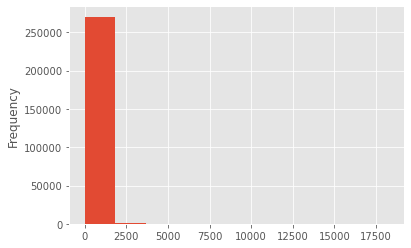

In [382]:
user_counts = rating_large["userId"].value_counts()
user_counts.plot(kind="hist")

In [420]:
# remove book which is not in dataframe
rated_movies = movies["id"]
print(rating_large.shape)
new_ratings = rating_large[rating_large['userId'].isin(rated_movies.index)]
print(new_ratings.shape)

(26024289, 4)
(4595915, 4)


In [447]:
new_ratings = rating_large[rating_large['userId'].isin(rated_movies.index)]
new_ratings = new_ratings[~new_ratings['userId'].isin(user_counts[user_counts > 150].index)]
new_ratings = new_ratings[~new_ratings['userId'].isin(user_counts[user_counts < 20].index)]
all_users = new_ratings["userId"].unique().tolist()
print(new_ratings.shape, len(all_users))

(1260476, 4) 21344


In [449]:
new_ratings = new_ratings.reset_index()
new_ratings.head(2)

,index,userId,movieId,rating,timestamp
0,0,1,110,1.0,1425941529
1,1,1,147,4.5,1425942435


In [450]:
all_users = new_ratings["userId"].unique().tolist()
print(len(all_users))
user_mapping = {}
for i, user in enumerate(all_users):
    user_mapping[user] = i + 1

21344


In [453]:
new_ratings["userId"] = new_ratings["userId"].astype("int")
new_ratings["userId"] = new_ratings["userId"].replace({"userId": user_mapping})
new_ratings.head(2)

In [455]:
new_ratings.to_csv("movies_rating_new.csv", index=False)

<AxesSubplot:ylabel='Frequency'>

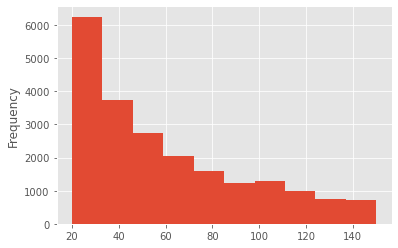

In [462]:
new_ratings["userId"].value_counts().plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

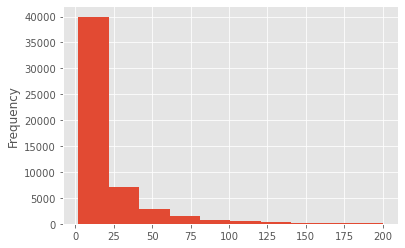

In [464]:
book_ratings["user_id"].value_counts().plot(kind="hist")

# movie model 

In [7]:
movies_recommender = pd.read_csv("movies_with_soup.csv")
movies_recommender.id

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
47215    439050
47216    111109
47217     67758
47218    227506
47219    461257
Name: id, Length: 47220, dtype: int64

In [8]:
movies_recommender.head(2)

,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,soup
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,toystory tomhankstimallenrickles ledwoodyandys...
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,jumanji robinwilliamsjonathanhydekirstendunst ...


In [32]:
movies_recommender_1 = movies_recommender_1.drop_duplicates(subset=['id'])

In [36]:
movies_recommender_1.to_csv("movie_with_soup_no_duplicates.csv", index=False)

In [9]:
movies_recommender_1 = movies_recommender.fillna('')
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_recommender_1['overview'][:10000])
cosine = cosine_similarity(tfidf_matrix, tfidf_matrix)
tfidf_matrix.shape

(10000, 276409)

In [28]:
def get_title_from_index(index):
    return movies_recommender_1.iloc[index]["title"]

def get_index_from_title(title):
    return movies_recommender_1[movies_recommender_1["title"] == title].index[0] # ["index"]

def get_recommendations(movie, cosine=cosine):
    movie_index = int(get_index_from_title(movie))
    print("movie_index:", movie_index)
    similar_movies = list(enumerate(cosine[movie_index]))
    sortedmovies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    print("movie_indices:", sortedmovies[1:6])
    print("{:>1} {:>40} \t  {:>15}".format("Index:", "Title:", "Similarity:"))
    for i, movie in enumerate(sortedmovies[1:6]):
        title = get_title_from_index(movie[0])
        similarity = movie[1]
        print("{:>5}: {:>40} \t {:>15.4f}".format(i + 1, title, similarity))

In [13]:
get_recommendations("Star Wars")

movie_index: 256
Index:                                   Title: 	      Similarity:
    1:                  The Empire Strikes Back 	          0.2576
    2:                       Return of the Jedi 	          0.1289
    3:                        Where Eagles Dare 	          0.0707
    4:                      The Thief of Bagdad 	          0.0669
    5:                        The Swan Princess 	          0.0621


In [22]:
stop_words = set(stopwords.words('english'))

def clean_data(x):
    x = str(x)
    word_tokens = word_tokenize(x)
    filtered_sentence = [w.lower() for w in word_tokens if w.isalpha()] # w.lower() not in stop_words and 
    x =  " ".join(filtered_sentence)
    return str.lower(x.replace(" ", ""))

features = ['title', 'cast', 'overview', 'genres', 'director'] # keywords
filledna = movies_recommender_1[features]

for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
print(filledna.shape)
filledna.head(2)

(47220, 5)


,title,cast,overview,genres,director
0,toystory,tomhankstimallendonrickles,ledbywoodyandystoyslivehappilyinhisroomuntilan...,animationcomedyfamily,johnlasseter
1,jumanji,robinwilliamsjonathanhydekirstendunst,whensiblingsjudyandpeterdiscoveranenchantedboa...,adventurefantasyfamily,joejohnston


In [23]:
filledna.index# = range(0, filledna.shape[0])

RangeIndex(start=0, stop=47220, step=1)

In [24]:
def create_soup(x):
    return x['title'] + ' ' + x['cast'] + ' ' + x['overview'] + ' ' + x['genres'] + ' ' + x['director']

movies_recommender_1['soup'] = filledna.apply(create_soup, axis=1)
movies_recommender_1['soup']

0        toystory tomhankstimallendonrickles ledbywoody...
1        jumanji robinwilliamsjonathanhydekirstendunst ...
2        grumpieroldmen waltermatthaujacklemmon afamily...
3        waitingtoexhale whitneyhoustonangelabassettlor...
4        fatherofthebridepartii stevemartindianekeatonm...
                               ...                        
47215    subdue leilahatamikouroshtahamielhamkorda risi...
47216    centuryofbirthing angelaquinoperrydizonhazelor...
47217    betrayal erikaeleniakadambaldwinjuliedupage wh...
47218    satantriumphant iwanmosschuchinnathalielissenk...
47219    queerama  yearsafterdecriminalisationofhomosex...
Name: soup, Length: 47220, dtype: object

In [33]:
count = CountVectorizer(stop_words='english', dtype=np.uintc)
count_matrix = count.fit_transform(movies_recommender_1['soup'][:10000])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [34]:
movies_recommender_1.shape

(45433, 22)

In [35]:
get_recommendations('Star Wars', cosine_sim2)

movie_index: 256
movie_indices: [(1154, 0.39999999999999997), (1167, 0.39999999999999997), (2513, 0.39999999999999997), (5243, 0.39999999999999997), (3670, 0.22360679774997896)]
Index:                                   Title: 	      Similarity:
    1:                  The Empire Strikes Back 	          0.4000
    2:                       Return of the Jedi 	          0.4000
    3: Star Wars: Episode I - The Phantom Menace 	          0.4000
    4: Star Wars: Episode II - Attack of the Clones 	          0.4000
    5:                                    X-Men 	          0.2236


In [20]:
get_recommendations('Star Wars', cosine_sim2)

movie_index: 256
Index:                                   Title: 	      Similarity:
    1:                  The Empire Strikes Back 	          0.4000
    2:                       Return of the Jedi 	          0.4000
    3: Star Wars: Episode I - The Phantom Menace 	          0.4000
    4: Star Wars: Episode II - Attack of the Clones 	          0.4000
    5:                                    X-Men 	          0.2236


In [599]:
movies_recommender_1.to_csv("movies_with_soup_1.csv", index=False)

In [562]:
movies_recommender_1 = pd.read_csv("movies_with_soup.csv")
movies_recommender_2 = movies_recommender_1.drop(["soup"], axis=1)
movies_recommender_2["index"] = range(0, movies_recommender_2.shape[0])
movies_recommender_2.to_csv("movies_with_soup_1.csv", index=False)
movies_recommender_2.head(2)

,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,index
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,0
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,1


In [569]:
movies_recommender_1 = pd.read_csv("movies_with_soup_1.csv")
print(movies_recommender_1.shape)
movies_recommender_1

(47220, 22)


,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,index
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,0
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Franais",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,1
2,15602,tt0113228,113228,en,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,"Romance, Comedy","Walter Matthau, Jack Lemmon, Ann-Margret",Howard Deutch,"fishing, best friend, duringcreditsstinger",English,United States of America,"Warner Bros., Lancaster Gate",11.712900,1995-12-22,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,101.0,https://images-na.ssl-images-amazon.com/images...,2
3,31357,tt0114885,114885,en,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","Comedy, Drama, Romance","Whitney Houston, Angela Bassett, Loretta Devine",Forest Whitaker,"based on novel, interracial relationship, sing...",English,United States of America,Twentieth Century Fox Film Corporation,3.859495,1995-12-22,Friends are the people who let you be yourself...,6.1,34.0,127.0,https://images-na.ssl-images-amazon.com/images...,3
4,11862,tt0113041,113041,en,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,"Steve Martin, Diane Keaton, Martin Short",Charles Shyer,"baby, midlife crisis, confidence",English,United States of America,"Sandollar Productions, Touchstone Pictures",8.387519,1995-02-10,Just When His World Is Back To Normal... Hes I...,5.7,173.0,106.0,https://images-na.ssl-images-amazon.com/images...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47215,439050,tt6209470,6209470,fa,,Subdue,Rising and falling between a man and woman.,"Drama, Family","Leila Hatami, Kourosh Tahami, Elham Korda",Hamid Nematollah,tragic love,NaN,Iran,NaN,0.072051,NaN,Rising and falling between a man and woman,4.0,1.0,90.0,NaN,47215
47216,111109,tt2028550,2028550,tl,Siglo ng Pagluluwal,Century of Birthing,An artist struggles to finish his work while a...,Drama,"Angel Aquino, Perry Dizon, Hazel Orencio",Lav Diaz,"artist, play, pinoy",NaN,Philippines,Sine Olivia,0.178241,2011-11-17,NaN,9.0,3.0,360.0,NaN,47216
47217,67758,tt0303758,303758,en,Betrayal,Betrayal,"When one of her hits goes wrong, a professiona...","Action, Drama, Thriller","Erika Eleniak, Adam Baldwin, Julie du Page",Mark L. Lester,NaN,English,United States of America,American World Pictures,0.903007,2003-08-01,A deadly game of wits.,3.8,6.0,90.0,NaN,47217
47218,227506,tt0008536,8536,en,Satana likuyushchiy,Satan Triumphant,"In a small town live two brothers, one a minis...",NaN,"Iwan Mosschuchin, Nathalie Lissenko, Pavel Pavlov",Yakov Protazanov,NaN,NaN,Russia,Yermoliev,0.003503,1917-10-21,NaN,0.0,0.0,87.0,NaN,47218


In [560]:
index = 0,
title = "Pirates of the Caribbean: The Curse of the Black Pearl"
movies_recommender_2.iloc[index]["title"], type(movies_recommender_2[movies_recommender_2["title"] == title].id)

('Toy Story', pandas.core.series.Series)

# user sql

In [43]:
users = pd.DataFrame(columns=[
    "id",
    "password", 
    "last_login", 
    "is_superuser", 
    "username", 
    "first_name", 
    "last_name", 
    "email", 
    "is_staff", 
    "is_active", 
    "date_joined"
])
users

,id,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined


In [44]:
for i in range(668): # i needed 668 user to match books and movies dataset users
    append = [
        i + 4, 
        'pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P8cUE9faCWBGDxBYJryGhD91xtUR9Pz8=', # djangouser1
        '2020-09-01 13:22:17', 
        0, 
        'user' + str(i + 4), 
        '', 
        '', 
        '', 
        0, 
        1, 
        '2020-09-01 13:22:40'
    ]
    users.loc[i] = append

In [45]:
users

,id,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined
0,4,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user4,,,,0,1,2020-09-01 13:22:40
1,5,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user5,,,,0,1,2020-09-01 13:22:40
2,6,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user6,,,,0,1,2020-09-01 13:22:40
3,7,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user7,,,,0,1,2020-09-01 13:22:40
4,8,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user8,,,,0,1,2020-09-01 13:22:40
...,...,...,...,...,...,...,...,...,...,...,...
663,667,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user667,,,,0,1,2020-09-01 13:22:40
664,668,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user668,,,,0,1,2020-09-01 13:22:40
665,669,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user669,,,,0,1,2020-09-01 13:22:40
666,670,pbkdf2_sha256$180000$jxPVgv7bd62e$6JfHQ1yjtb8P...,2020-09-01 13:22:17,0,user670,,,,0,1,2020-09-01 13:22:40


In [46]:
users.to_csv("users_script.csv", index=False)

In [55]:
rating_small = pd.read_csv("datasets-movies/dataset-the-movie/ratings_small.csv")
print(rating_small.shape)
rating_small.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [56]:
all_users = rating_small["userId"].unique().tolist()
len(all_users) # 1 to 671

671

In [58]:
rating_small["timestamp"] = rating_small["timestamp"].apply(lambda x: pd.Timestamp(x, unit='s'))
rating_small.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59


In [59]:
rating_small = rating_small.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'})
rating_small.to_csv("movie_ratings_end.csv", index=False)

# book ratings same as movies

In [126]:
books_ratings = pd.read_csv('datasets-books/dataset-goodbooks-10k/ratings.csv')
print(books_ratings.shape)
books_ratings.head(2)

(981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3


<AxesSubplot:ylabel='Frequency'>

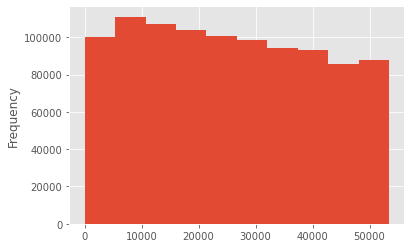

In [127]:
books_ratings["user_id"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

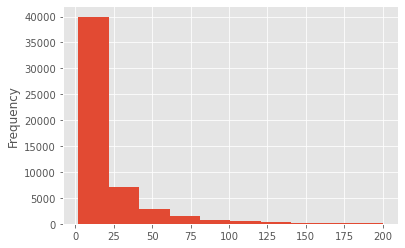

In [132]:
user_counts = books_ratings["user_id"].value_counts()
user_counts.plot(kind="hist")

In [169]:
all_books = pd.read_csv("all_books_with_descr_4_with_clean_true_id_with_soup.csv")
print(all_books.shape)
all_books.head(2)

(10000, 27)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories,clean_description,soup
0,0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,"Science Fiction, Adventure novel, Alternate hi...",the hunger games takes place nation known pane...,thehungergames suzannecollins thehungergamesta...
1,1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPr",1997.0,Harry Potter and the Philosophers Stone,Harry Potter and the Philosophers Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...","Childrens literature, Fantasy Speculative fict...",before start novel voldemort considered evil p...,harrypotterandthephilosophersstone rowlingmary...


In [178]:
all_books_ratings = books_ratings[~books_ratings['user_id'].isin(user_counts[user_counts != 20].index)]
# all_books_ratings = all_books_ratings[~all_books_ratings['user_id'].isin(user_counts[user_counts < 10].index)]
all_users = all_books_ratings["user_id"].unique().tolist()
print(all_books_ratings.shape, len(all_users))

(12640, 3) 632


In [179]:
all_books_ratings

,book_id,user_id,rating
40560,406,29379,4
40563,406,31212,2
46133,462,21496,4
46147,462,26257,4
46150,462,27251,4
...,...,...,...
981490,9998,10643,4
981542,9998,42123,5
981558,9998,52087,4
981576,9999,4109,3


In [177]:
all_books_ratings["user_id"].value_counts()

47089    10
19811    10
15597    10
42238    10
9494     10
         ..
39558    10
6806     10
43680    10
49829    10
16384    10
Name: user_id, Length: 1395, dtype: int64

In [ ]:
all_users = all_books_ratings["user_id"].unique().tolist()
print(len(all_users))
user_mapping = {}
for i, user in enumerate(all_users):
    user_mapping[user] = i + 1
user_mapping

In [189]:
all_books_ratings["user_id"] = all_books_ratings["user_id"].astype("int")
all_books_ratings = all_books_ratings.replace({"user_id": user_mapping})
all_books_ratings.head(2)

,book_id,user_id,rating
40560,406,1,4
40563,406,2,2


In [192]:
all_books_ratings.to_csv("all_books_ratings_new.csv", index=False)

In [182]:
all_books_ratings.head(2)

,book_id,user_id,rating
40560,406,29379,4
40563,406,31212,2


In [188]:
all_books_ratings.replace({"user_id": user_mapping})

,book_id,user_id,rating
40560,406,1,4
40563,406,2,2
46133,462,3,4
46147,462,4,4
46150,462,5,4
...,...,...,...
981490,9998,516,4
981542,9998,395,5
981558,9998,592,4
981576,9999,575,3


In [191]:
all_books_ratings["rating"]

40560     4
40563     2
46133     4
46147     4
46150     4
         ..
981490    4
981542    5
981558    4
981576    3
981739    4
Name: rating, Length: 12640, dtype: int64

# trending books and movies

In [5]:
books_dataset = pd.read_csv("all_books_with_descr_4_with_clean_true_id_with_soup.csv")
books_dataset = books_dataset.rename(columns={'average_rating': 'vote_average', 'ratings_count': 'vote_count'})
print(books_dataset.shape)
books_dataset.head(2)

(10000, 27)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,vote_average,vote_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,categories,clean_description,soup
0,0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games takes place in a nation know...,"Science Fiction, Adventure novel, Alternate hi...",the hunger games takes place nation known pane...,thehungergames suzannecollins thehungergamesta...
1,1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPr",1997.0,Harry Potter and the Philosophers Stone,Harry Potter and the Philosophers Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Before the start of the novel, Voldemort, con...","Childrens literature, Fantasy Speculative fict...",before start novel voldemort considered evil p...,harrypotterandthephilosophersstone rowlingmary...


In [3]:
movies_dataset = pd.read_csv("movies_with_soup_no_duplicates.csv")
print(movies_dataset.shape)
movies_dataset.head(2)

(45433, 22)


,id,imdb_id,clean_imdb_id,original_language,original_title,title,overview,genres,cast,director,keywords,spoken_languages,production_countries,production_companies,popularity,release_date,tagline,vote_average,vote_count,runtime,poster,soup
0,862,tt0114709,114709,en,Toy Story,Toy Story,"Led by Woody, Andys toys live happily in his r...","Animation, Comedy, Family","Tom Hanks, Tim Allen, Don Rickles",John Lasseter,"jealousy, toy, boy",English,United States of America,Pixar Animation Studios,21.946943,1995-10-30,NaN,7.7,5415.0,81.0,https://images-na.ssl-images-amazon.com/images...,toystory tomhankstimallendonrickles ledbywoody...
1,8844,tt0113497,113497,en,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst",Joe Johnston,"board game, disappearance, based on childrens ...","English, Français",United States of America,"TriStar Pictures, Teitler Film, Interscope Com...",17.015539,1995-12-15,Roll the dice and unleash the excitement!,6.9,2413.0,104.0,https://images-na.ssl-images-amazon.com/images...,jumanji robinwilliamsjonathanhydekirstendunst ...


In [8]:
C = books_dataset['vote_average'].mean()
m = books_dataset['vote_count'].quantile(0.9)
trend_books = books_dataset.copy().loc[books_dataset['vote_count'] >= m]

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

trend_books['score'] = trend_books.apply(weighted_rating, axis=1)
trend_books = trend_books.sort_values('score', ascending=False)
trend_books[['id', 'title', 'vote_count', 'vote_average', 'score']].head(10)

,id,title,vote_count,vote_average,score
24,24,Harry Potter and the Deathly Hallows,1746574,4.61,4.578926
26,26,Harry Potter and the Half-Blood Prince,1678823,4.54,4.511454
17,17,Harry Potter and the Prisoner of Azkaban,1832823,4.53,4.504224
23,23,Harry Potter and the Goblet of Fire,1753043,4.53,4.503111
421,421,Harry Potter Series Box Set,190050,4.74,4.495659
134,134,A Storm of Swords,469022,4.54,4.450127
191,191,The Name of the Wind,400101,4.55,4.445690
20,20,Harry Potter and the Order of the Phoenix,1735368,4.46,4.436452
1,1,Harry Potter and the Philosophers Stone,4602479,4.44,4.431228
160,160,The Return of the King,463959,4.51,4.424371


In [9]:
C = movies_dataset['vote_average'].mean()
m = movies_dataset['vote_count'].quantile(0.9)
trend_movies = movies_dataset.copy().loc[movies_dataset['vote_count'] >= m]

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

trend_movies['score'] = trend_movies.apply(weighted_rating, axis=1)
trend_movies = trend_movies.sort_values('score', ascending=False)
trend_movies[['id', 'title', 'vote_count', 'vote_average', 'score']].head(10)

,id,title,vote_count,vote_average,score
314,278,The Shawshank Redemption,8358.0,8.5,8.445871
834,238,The Godfather,6024.0,8.5,8.425442
10306,19404,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421477
12477,155,The Dark Knight,12269.0,8.3,8.265479
2842,550,Fight Club,9678.0,8.3,8.256387
292,680,Pulp Fiction,8670.0,8.3,8.251408
522,424,Schindlers List,4436.0,8.3,8.206643
23656,244786,Whiplash,4376.0,8.3,8.205408
5480,129,Spirited Away,3968.0,8.3,8.196059
2210,637,Life Is Beautiful,3643.0,8.3,8.187177


# new user to csv

In [10]:
books_ratings = pd.read_csv("static/books_ratings.csv")
print(books_ratings.shape)
books_ratings.head(2)

(981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [11]:
movies_ratings = pd.read_csv("static/movies_ratings.csv")
print(movies_ratings.shape)
movies_ratings.head(2)

(100004, 4)


,user_id,movie_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [26]:
int(time.time()), time.time(), type(time.time()), pd.to_datetime(int(time.time()), unit='s')

(1599059342, 1599059342.8899164, float, Timestamp('2020-09-02 15:09:02'))

In [30]:
with open("static/movies_ratings.csv", "a") as f:
    append = "672" + "," + "6565" + "," + "4.5" + "," + str(int(time.time())) + "\n"
    f.write(append)

In [32]:
with open("static/books_ratings.csv", "a") as f:
    for i in range(3):
        append = "10001" + "," + "672" + "," + "4" + "\n"
        f.write(append)

In [33]:
len(books_ratings["user_id"].unique().tolist()), len(movies_ratings["user_id"].unique().tolist())

(53424, 671)

# 671 users for books

<AxesSubplot:ylabel='Frequency'>

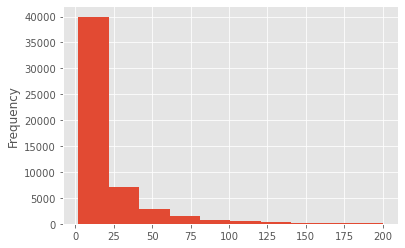

In [34]:
user_counts = books_ratings["user_id"].value_counts()
user_counts.plot(kind="hist")

In [35]:
all_books_ratings = books_ratings[~books_ratings['user_id'].isin(user_counts[user_counts != 20].index)]
# all_books_ratings = all_books_ratings[~all_books_ratings['user_id'].isin(user_counts[user_counts < 10].index)]
all_users = all_books_ratings["user_id"].unique().tolist()
print(all_books_ratings.shape, len(all_users))

(12640, 3) 632


In [36]:
all_books_ratings["user_id"].value_counts()

36862    20
30252    20
46772    20
1714     20
32413    20
         ..
493      20
2532     20
27072    20
405      20
18489    20
Name: user_id, Length: 632, dtype: int64

In [ ]:
all_users = all_books_ratings["user_id"].unique().tolist()
print(len(all_users))
user_mapping = {}
for i, user in enumerate(all_users):
    user_mapping[user] = i + 1
user_mapping

In [38]:
all_books_ratings["user_id"] = all_books_ratings["user_id"].astype("int")
all_books_ratings = all_books_ratings.replace({"user_id": user_mapping})
all_books_ratings.head(2)

,book_id,user_id,rating
40560,406,1,4
40563,406,2,2


In [50]:
all_books_ratings["book_id"] = all_books_ratings["book_id"].apply(lambda x: x - 1)

In [51]:
all_books_ratings.to_csv("books_ratings_632_user.csv", index=False)

# new model with 671 users

In [57]:
rcsystem_books_671_ratings = pd.read_csv("rcsystem_bookratings.csv")
rcsystem_books_671_ratings = rcsystem_books_671_ratings[['book_id', 'user_id', 'rating']]
print(rcsystem_books_671_ratings.shape)
rcsystem_books_671_ratings.to_csv("books_ratings_632_user.csv", index=False)
rcsystem_books_671_ratings.head(2)

(12679, 3)


,book_id,user_id,rating
0,7331,1,5
1,7861,1,5


In [58]:
books_671_ratings = pd.read_csv("books_ratings_632_user.csv")

reader = Reader()
data = Dataset.load_from_df(books_671_ratings[['book_id', 'user_id', 'rating']], reader)
kf = KFold(n_splits=5)
svd = SVD()

for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8914
RMSE: 0.8776
RMSE: 0.8984
RMSE: 0.8840
RMSE: 0.9038


In [59]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [60]:
svd.predict(1, 302, 3), svd.predict(1, 302, 3).est

(Prediction(uid=1, iid=302, r_ui=3, est=3.695262066530383, details={'was_impossible': False}),
 3.695262066530383)

In [61]:
dump.dump("user_based_book_671.dump", algo=svd)
# _, loaded_algo = dump.load("user_based_book")